# TensorRider Algorithm

In [1]:
import numpy as np
import tensorflow as tf
import tensorlayer as tl
from matplotlib import pyplot as plt

In [2]:
sess = tf.InteractiveSession()

In [3]:
def preprocess(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
#     mono = 0.2989 * r + 0.5870 * g + 0.1140 * b
#     mono = 0.5 * r + 0.25 * g + 0.25 * b
    rgb = rgb * (1. / 255)
    return rgb

In [4]:
def prepareDataArrays(iterator):
    X = np.empty((0, 14400))
    y = np.empty((0,1))
    X_buffer = np.empty((0, 14400))
    y_buffer = np.empty((0,1))
    
    recordCounter = 0;

    for string_record in iterator:
        recordCounter += 1

        example = tf.train.Example()
        example.ParseFromString(string_record)
        imageString = (example.features.feature['image'].bytes_list.value[0])
        label = (example.features.feature['label'].int64_list.value[0])
        
        image = np.fromstring(imageString, dtype=np.uint8)
        image = image.reshape((60, 80, 3))
        image = preprocess(image)
        image = image.reshape((14400))

        X_buffer = np.append(X_buffer, [image], axis=0)
        y_buffer = np.append(y_buffer, label)
        
        if recordCounter % 100 == 0:
            print(recordCounter,end = '->')
        if recordCounter % 1000 == 0:
            print("Merging")
            X = np.append(X, [X_buffer])
            y = np.append(y, [y_buffer])
            X_buffer = np.empty((0, 14400))
            y_buffer = np.empty((0,1))
    
    print("Done")        
    X = np.append(X, [X_buffer])
    y = np.append(y, y_buffer)
    
    X = X.reshape((recordCounter, 14400))
    y = y.reshape((recordCounter,))
    y = np.round(y / 6)
    y = y + 7
    return X, y

In [5]:
trainIterator = tf.python_io.tf_record_iterator(path="train.tfrecords")
valIterator = tf.python_io.tf_record_iterator(path="val.tfrecords")
testIterator = tf.python_io.tf_record_iterator(path="test.tfrecords")

# TFRecords -> Arrays

In [6]:
print("\nTrain...")
X_train, y_train = prepareDataArrays(trainIterator)
print("\nVal...")
X_val, y_val = prepareDataArrays(valIterator)
print("\nTest...")
X_test, y_test = prepareDataArrays(testIterator)


Train...


D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


100->200->300->400->500->600->700->800->900->1000->Merging
1100->1200->1300->1400->1500->1600->1700->1800->1900->2000->Merging
2100->2200->2300->2400->2500->2600->2700->2800->2900->3000->Merging
3100->3200->3300->3400->3500->3600->3700->3800->3900->4000->Merging
4100->4200->4300->4400->4500->4600->4700->4800->4900->5000->Merging
5100->5200->5300->5400->5500->5600->5700->5800->5900->6000->Merging
6100->6200->6300->6400->6500->6600->6700->6800->6900->7000->Merging
7100->7200->7300->7400->7500->7600->7700->7800->7900->8000->Merging
8100->8200->8300->8400->8500->8600->8700->8800->8900->9000->Merging
9100->9200->9300->9400->9500->9600->9700->9800->9900->10000->Merging
10100->10200->10300->10400->10500->10600->10700->10800->10900->11000->Merging
11100->11200->11300->11400->11500->11600->11700->11800->11900->12000->Merging
12100->12200->12300->12400->12500->12600->12700->12800->12900->13000->Merging
13100->13200->13300->13400->13500->13600->13700->13800->13900->14000->Merging
14100->14200->14

# Arrays -> NPZ File

In [7]:
np.savez("arrays_norm.npz", xtr = X_train, ytr = y_train, xval = X_val, yval = y_val, xt = X_test, yt = y_test)

# NPZ File -> Arrays

In [5]:
npRecall = np.load("arrays_norm.npz")
X_train = npRecall["xtr"]
y_train = npRecall["ytr"]
X_val = npRecall["xval"]
y_val = npRecall["yval"]
X_test = npRecall["xt"]
y_test = npRecall["yt"]

(array([8.0000e+00, 1.2000e+01, 1.0000e+01, 5.5900e+02, 5.0030e+03,
        8.0860e+03, 2.7650e+03, 1.1973e+04, 2.2740e+03, 6.7780e+03,
        3.9620e+03, 6.6900e+02, 2.8000e+01, 1.4000e+01]),
 array([ 0.        ,  0.92857143,  1.85714286,  2.78571429,  3.71428571,
         4.64285714,  5.57142857,  6.5       ,  7.42857143,  8.35714286,
         9.28571429, 10.21428571, 11.14285714, 12.07142857, 13.        ]),
 <a list of 14 Patch objects>)

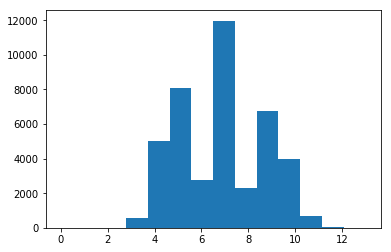

In [6]:
plt.hist(y_train, 14)

# Define the Neural Network

In [7]:
x = tf.placeholder(tf.float32, shape=[None, 14400], name='x')
y_ = tf.placeholder(tf.int64, shape=[None], name='y_')

In [8]:
network = tl.layers.InputLayer(x, name='input')
# network = tl.layers.DropoutLayer(network, keep=0.8, name='drop1')
network = tl.layers.DenseLayer(network, 4800, tf.nn.relu, name='relu1')
network = tl.layers.DenseLayer(network, n_units=15, act=tf.identity, name='output')

[TL] InputLayer  input: (?, 14400)
[TL] DenseLayer  relu1: 4800 relu
[TL] DenseLayer  output: 15 identity


In [9]:
y = network.outputs
cost = tl.cost.cross_entropy(y, y_, name='cost')
correct_prediction = tf.equal(tf.argmax(y, 1), y_)
acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

y_op = tf.argmax(tf.nn.softmax(y), 1)

In [10]:
train_params = network.all_params
train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost, var_list=train_params)

In [11]:
tl.layers.initialize_global_variables(sess)

ResourceExhaustedError: OOM when allocating tensor with shape[14400,4800] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: relu1/W/Adam_1/Assign = Assign[T=DT_FLOAT, _class=["loc:@relu1/W"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](relu1/W/Adam_1, relu1/W/Adam_1/Initializer/zeros)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'relu1/W/Adam_1/Assign', defined at:
  File "D:\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "D:\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "D:\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 421, in run_forever
    self._run_once()
  File "D:\Anaconda3\envs\tensorflow\lib\asyncio\base_events.py", line 1425, in _run_once
    handle._run()
  File "D:\Anaconda3\envs\tensorflow\lib\asyncio\events.py", line 127, in _run
    self._callback(*self._args)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\platform\asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-793a1bb20640>", line 2, in <module>
    train_op = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost, var_list=train_params)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\optimizer.py", line 369, in minimize
    name=name)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\optimizer.py", line 520, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\adam.py", line 132, in _create_slots
    self._zeros_slot(v, "v", self._name)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\optimizer.py", line 910, in _zeros_slot
    named_slots[_var_key(var)] = slot_creator.create_zeros_slot(var, op_name)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\slot_creator.py", line 174, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\slot_creator.py", line 148, in create_slot_with_initializer
    dtype)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\slot_creator.py", line 67, in _create_slot_var
    validate_shape=validate_shape)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1297, in get_variable
    constraint=constraint)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1093, in get_variable
    constraint=constraint)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 439, in get_variable
    constraint=constraint)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 408, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 800, in _get_single_variable
    use_resource=use_resource)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2157, in variable
    use_resource=use_resource)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2147, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2130, in default_variable_creator
    constraint=constraint)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 233, in __init__
    constraint=constraint)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\variables.py", line 371, in _init_from_args
    validate_shape=validate_shape).op
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\state_ops.py", line 280, in assign
    validate_shape=validate_shape)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 61, in assign
    use_locking=use_locking, name=name)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "D:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[14400,4800] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: relu1/W/Adam_1/Assign = Assign[T=DT_FLOAT, _class=["loc:@relu1/W"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](relu1/W/Adam_1, relu1/W/Adam_1/Initializer/zeros)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
network.print_params()

In [ ]:
network.print_layers()

# (Optional) Setting up TensorBoard

In [14]:
acc_summ = tf.summary.scalar('acc', acc)
cost_summ = tf.summary.scalar('cost', cost)
summary = tf.summary.merge_all()  
writer = tf.summary.FileWriter('./logs')  
writer.add_graph(sess.graph) 

# Start Training

In [15]:
tl.utils.fit(
    sess, network, train_op, cost, X_train, y_train, x, y_, acc=acc, 
    batch_size=73, n_epoch=500, print_freq=5, X_val=X_val, y_val=y_val, eval_train=True, 
    tensorboard=True, tensorboard_epoch_freq=5, tensorboard_weight_histograms=False, tensorboard_graph_vis=False)

[TL] Setting up tensorboard ...
[TL] [!] logs/ exists ...
[TL] Finished! use $tensorboard --logdir=logs/ to start server
[TL] Start training the network ...
[TL] Epoch 1 of 500 took 18.476589s
[TL]    train loss: 1.293642
[TL]    train acc: 0.595665
[TL]    val loss: 1.357201
[TL]    val acc: 0.577923
[TL] Epoch 5 of 500 took 16.254562s
[TL]    train loss: 1.207525
[TL]    train acc: 0.573965
[TL]    val loss: 1.173391
[TL]    val acc: 0.571967
[TL] Epoch 10 of 500 took 16.855151s
[TL]    train loss: 0.812516
[TL]    train acc: 0.681726
[TL]    val loss: 0.833506
[TL]    val acc: 0.690292
[TL] Epoch 15 of 500 took 16.709492s
[TL]    train loss: 0.659479
[TL]    train acc: 0.753377
[TL]    val loss: 0.722115
[TL]    val acc: 0.763550
[TL] Epoch 20 of 500 took 16.497277s
[TL]    train loss: 0.823224
[TL]    train acc: 0.692457
[TL]    val loss: 1.042314
[TL]    val acc: 0.668056
[TL] Epoch 25 of 500 took 16.334446s
[TL]    train loss: 0.596848
[TL]    train acc: 0.756392
[TL]    val loss

KeyboardInterrupt: 

# Test the Neural Network

In [16]:
tl.utils.test(sess, network, acc, X_test, y_test, x, y_, batch_size=None, cost=cost)

[TL] Start testing the network ...
[TL]    test loss: 0.773695
[TL]    test acc: 0.729220


# Save the Trained Model

In [13]:
tl.files.save_npz(network.all_params, name='model_old.npz')
sess.close()

[TL] [*] model.npz saved


# Load the Trained Model

In [14]:
tl.files.load_and_assign_npz(sess=sess, name='model_old.npz', network=network)

[TL] [*] Load model_old.npz SUCCESS!


# Controlling TensorRider Using the Generated Model

In [15]:
import cv2
import urllib.request
import numpy as np
import socket
import threading
from time import ctime,sleep
import string

remoteImage = np.array([])
stream = urllib.request.urlopen('http://192.168.73.73:8080/?action=stream&ignored.mjpg')
bytes = bytes()

In [16]:
def Image_Refreshing_Thread():
    global remoteImage
    global stream
    global bytes
    while True:
        bytes += stream.read(1024)
        a = bytes.find(b'\xff\xd8')
        b = bytes.find(b'\xff\xd9')
        if a != -1 and b != -1:
            jpg = bytes[a:b+2]
            bytes = bytes[b+2:]
            i = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
            i = rgb2mono(i)
            remoteImage = i.reshape((1,4800))

In [17]:
def Controlling_Thread():
    global remoteImage
    addr=('192.168.73.73',51423)
    s=socket.socket(socket.AF_INET,socket.SOCK_DGRAM)
    while True:
        direction = tl.utils.predict(sess, network, remoteImage, x, y_op, batch_size=None)
        msgCtrl_Udp = str(50) + "," + str((direction[0] - 3) * 26)
#         print(msgCtrl_Udp)
        s.sendto(msgCtrl_Udp.encode('utf-8'), addr)
        sleep(0.1)

In [18]:
RefreshImageThread = threading.Thread(target = Image_Refreshing_Thread)
RefreshImageThread.start()

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


In [19]:
ControllingThread = threading.Thread(target = Controlling_Thread)
ControllingThread.start()

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':
